## LSTM Model

This model is purely for making of the LSTM model to predict the number of dengue cases in a time series data.  
The entire Singapore is divided into 4 regions.  
Each region have it's individual model trained.  
The architecture of the model is the same.  
The weights are the only difference, I hope.  

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import stats models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import other lib
from typing import Union
pd.set_option('display.max_columns', None)

Here are the steps I will take:   
1. [EDA](#EDA)    
2. [Preprocessing](#Preprocessing)   
3. [Model Creation](#Model-Creation)   
4. [Training](#Training)   
5. [Results](#Results)    

EDA: Explore the data again to decide on strategy of crafting an LSTM.  
Preprocessing: Prepare the data for LSTM.  
Model Creation: Make LSTM model.  
Training: Train the model.  
Results: Present the results of LSTM.  

## EDA

In [2]:
df_central = pd.read_csv('../data/df_central_merge.csv', index_col=[0])
df_east = pd.read_csv('../data/df_east_merge.csv', index_col=[0])
df_north = pd.read_csv('../data/df_north_merge.csv', index_col=[0])
df_west = pd.read_csv('../data/df_west_merge.csv', index_col=[0])
df_ne = pd.read_csv('../data/df_northeast_merge.csv', index_col=[0])

In [3]:
df_central.head()

,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,mean_wind_sp,min_temp,dengue_fever,dengue,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
0,2013,21,Central,85,92.4,43.9,34.3,1,28.5,4.770000,23.7,33.0,30.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013,22,Central,99,123.0,88.9,33.8,1,28.3,5.740000,23.8,29.0,28.0,9.0,3.0,-4.0,0.0,-2.0,0.0,-1.0,0.0,1.0,0.0
2,2013,23,Central,193,375.0,43.9,35.4,1,28.3,6.200000,23.4,56.0,52.0,18.0,4.0,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
3,2013,24,Central,141,65.9,91.8,34.8,1,30.0,7.182857,23.9,42.0,39.0,14.0,2.0,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
4,2013,25,Central,119,0.0,40.7,35.3,0,30.5,7.034286,25.6,25.0,23.0,8.0,2.0,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0


In [4]:
df_list = [df_central, df_east, df_north, df_west]
for df in df_list:
    print(f"Data frames is of the following shape: {df.shape}")

Data frames is of the following shape: (392, 23)
Data frames is of the following shape: (392, 23)
Data frames is of the following shape: (392, 23)
Data frames is of the following shape: (392, 23)


The total number of data points I have is 392.  
This means that I have a total of about 7 years and a quater of data.  

In [5]:
df_central.head(10)

,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,mean_wind_sp,min_temp,dengue_fever,dengue,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
0,2013,21,Central,85,92.4,43.9,34.3,1,28.5,4.770000,23.7,33.0,30.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013,22,Central,99,123.0,88.9,33.8,1,28.3,5.740000,23.8,29.0,28.0,9.0,3.0,-4.0,0.0,-2.0,0.0,-1.0,0.0,1.0,0.0
2,2013,23,Central,193,375.0,43.9,35.4,1,28.3,6.200000,23.4,56.0,52.0,18.0,4.0,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
3,2013,24,Central,141,65.9,91.8,34.8,1,30.0,7.182857,23.9,42.0,39.0,14.0,2.0,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
4,2013,25,Central,119,0.0,40.7,35.3,0,30.5,7.034286,25.6,25.0,23.0,8.0,2.0,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0
5,2013,26,Central,160,123.7,47.2,34.9,1,29.2,5.860000,23.7,26.0,24.0,9.0,3.0,1.0,18.0,1.0,17.0,1.0,7.0,1.0,1.0
6,2013,27,Central,281,80.1,51.5,33.6,1,28.5,7.160000,23.2,18.0,17.0,8.0,1.0,-8.0,-9.0,-7.0,-8.0,-1.0,-2.0,-2.0,-3.0
7,2013,28,Central,273,448.4,49.3,33.2,1,27.8,6.285714,22.3,16.0,16.0,8.0,3.0,-2.0,6.0,-1.0,6.0,0.0,1.0,2.0,4.0
8,2013,29,Central,220,84.3,60.5,34.6,1,28.1,6.754286,24.0,14.0,13.0,8.0,2.0,-2.0,0.0,-3.0,-2.0,0.0,0.0,-1.0,-3.0
9,2013,30,Central,147,112.9,43.6,34.4,1,28.5,7.377143,23.1,12.0,11.0,9.0,1.0,-2.0,0.0,-2.0,1.0,1.0,1.0,-1.0,0.0


The LSTM expects the input data to be of shape `(batch_size, time_steps, num_features)`.   

In my case, I have a total of at 9 + 1 input variables that I can select from:  
9 inputs:  
`['total_daily_rainfall', 'max_wind_sp', 'max_temp', 'rainy_day', 'mean_temp',
'mean_wind_sp', 'min_temp', 'dengue_fever', 'mosquito']`   
1 target/ historical variable:  
`['no_cases']`

So, my `num_features` would be in a range from 1 to 12.   
Of course, the exact number will have to determined by experiment, emperically.  

The `time_steps` is how many previous time-points the LSTM should use for prediction.   
For example, if I want to use the past 12 months of data to predict the next month, my `time_steps` would be 12.   
I will likely try a `time_steps` of 6and 12.

The `batch_size` is how many samples I want to feed to the LSTM at once.   
For example, if I have 1000 samples of data and I want to train the LSTM on 100 samples at a time, my `batch_size` would be 100.  

In [6]:
# only use 9 features out of the all other features, +1 target variable
possible_features = ['no_cases', 'total_daily_rainfall', 'max_wind_sp', 'max_temp', 'rainy_day', 'mean_temp',
'mean_wind_sp', 'min_temp', 'dengue_fever', 'mosquito']

Check the data have a seasonality.  
Plot all input features for observation.

In [7]:
def plot_data(df, features:list, figsize = (18,600)):
    '''Plot the selected features for observation.
    args:
        df: data to use
        features: list of features to plot
        figsize: size of data to plot, default = (18,600)
    '''
    plt.figure(figsize=figsize)
    i = 1
    for feature in features:
        plt.subplot(df.shape[0], 1, i)
        plt.plot(df.index, df[feature])
        plt.title(feature, y=0.7, loc='right')
        i += 1
    plt.show()

In [8]:
# plot PACF to check if data is stationary/ seasonal
def plot_my_PACF(df, features:list):
    warnings.filterwarnings('ignore')
    for feature in features:
        # Generate autocorrelation plot on data.
        plot_pacf(df[feature], lags = 54, title=feature+'_pacf');
        
def plot_my_ACF(df, features:list):
    warnings.filterwarnings('ignore')
    for feature in features:
        # Generate autocorrelation plot on data.
        plot_acf(df[feature], lags = 54, title=feature+'_acf');

In [9]:
df_central.loc[df_central['no_cases']>1000]

,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,mean_wind_sp,min_temp,dengue_fever,dengue,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
61,2014,30,Central,1082,124.9,100.1,34.6,1,29.6,8.905714,23.0,14.0,12.0,8.0,2.0,-4.0,-5.0,-3.0,-3.0,-3.0,-6.0,1.0,1.0
62,2014,31,Central,1111,378.4,61.2,32.9,1,28.4,7.794286,22.9,15.0,14.0,9.0,1.0,1.0,5.0,2.0,5.0,1.0,4.0,-1.0,-2.0
63,2014,32,Central,1101,92.1,50.8,33.7,1,28.0,8.080000,22.6,14.0,13.0,9.0,2.0,-1.0,-2.0,-1.0,-3.0,0.0,-1.0,1.0,2.0
64,2014,33,Central,1143,210.6,51.8,32.7,1,27.5,6.880000,23.0,15.0,14.0,8.0,1.0,1.0,2.0,1.0,2.0,-1.0,-1.0,-1.0,-2.0
369,2020,23,Central,1281,183.4,46.9,34.0,1,28.8,7.442857,24.0,23.0,22.0,18.0,4.0,5.0,-1.0,5.0,-1.0,3.0,0.0,0.0,-1.0
373,2020,27,Central,3421,95.5,41.1,33.6,1,29.1,7.803030,23.6,24.0,23.0,16.0,5.0,-2.0,2.0,-2.0,2.0,-4.0,-4.0,0.0,0.0
378,2020,32,Central,5419,16.0,59.8,34.7,1,29.3,7.874286,23.6,24.0,22.0,15.0,4.0,-6.0,-8.0,-6.0,-8.0,-1.0,-1.0,-1.0,0.0
384,2020,38,Central,3847,149.5,62.2,34.5,1,28.1,7.660606,20.9,12.0,11.0,8.0,2.0,0.0,2.0,-1.0,0.0,-3.0,-4.0,-1.0,-1.0


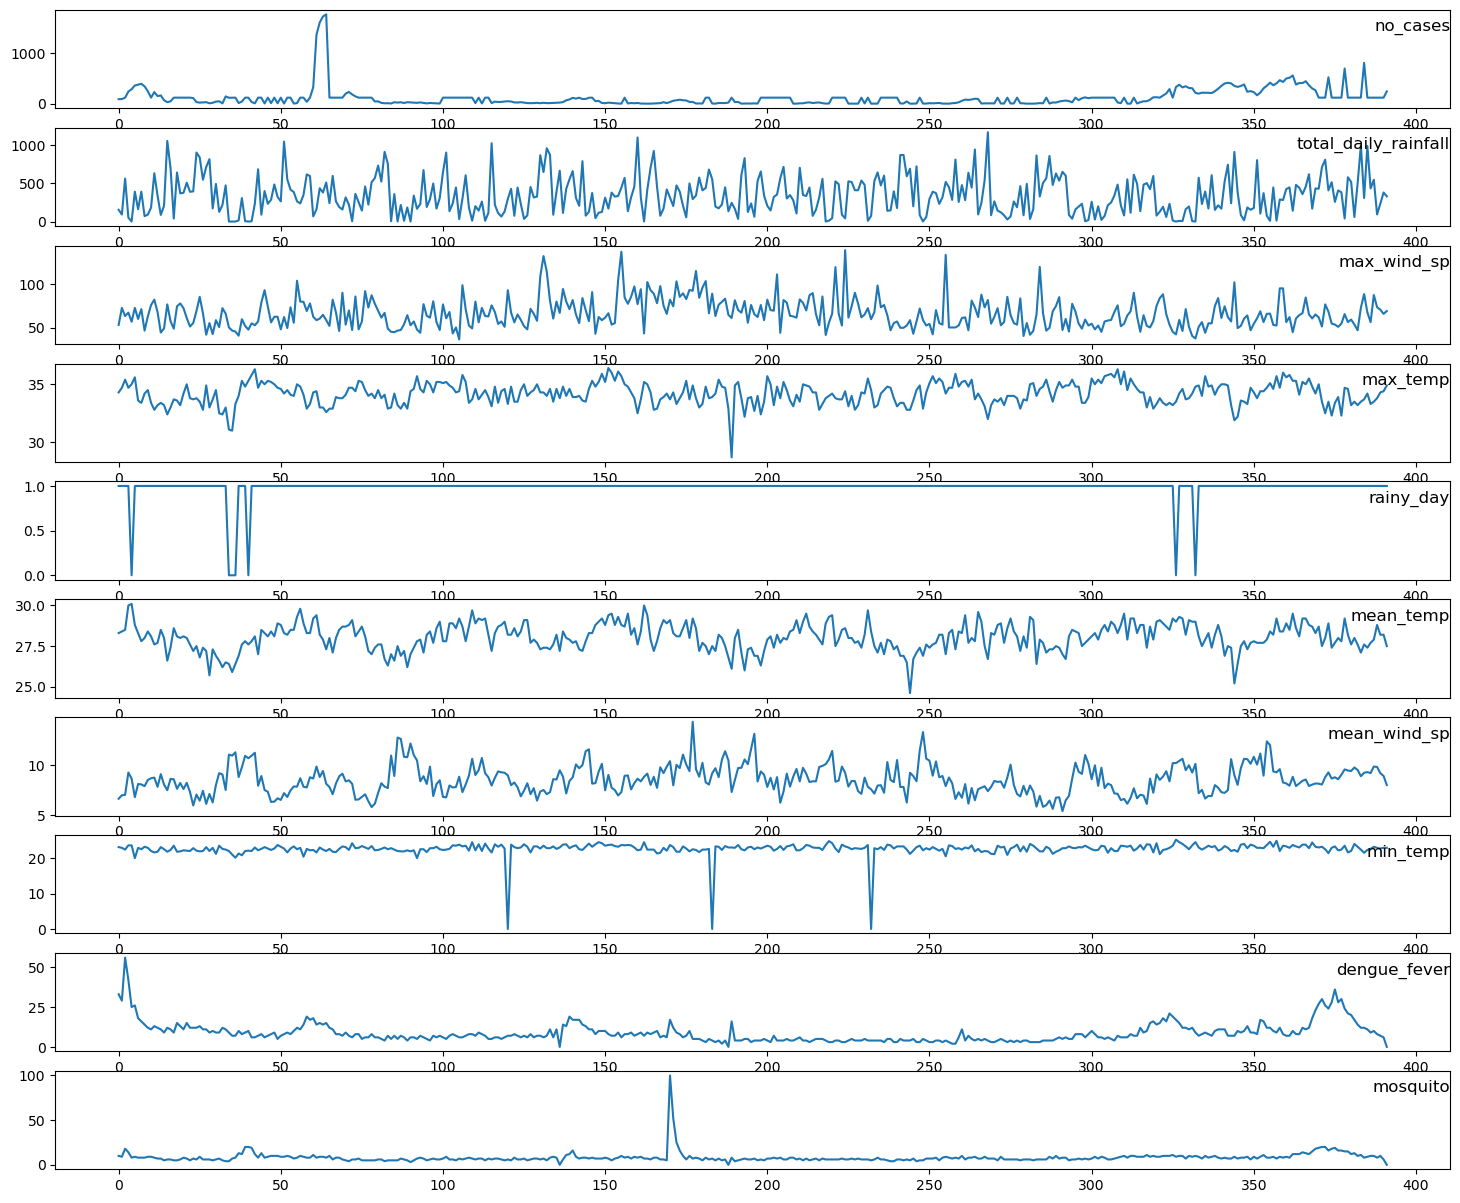

In [10]:
plot_data(df_west, possible_features)

Because the data trend seems very off close to 400, I thinl it will make more sense to cut it off.   
This is becuase machine learning can't predict on a trend that's not seen before.   
Knowing that 1 year have 52.14 weeks in 1 year.  
$52.14 \times 7 \approx 365$  
365 data points will be selected to create and test the model.  


In [11]:
df_east = df_east[:366]
df_central = df_central[:366]
df_north = df_ne[:366]
df_ne = df_ne[:366]
df_west = df_west[:366]

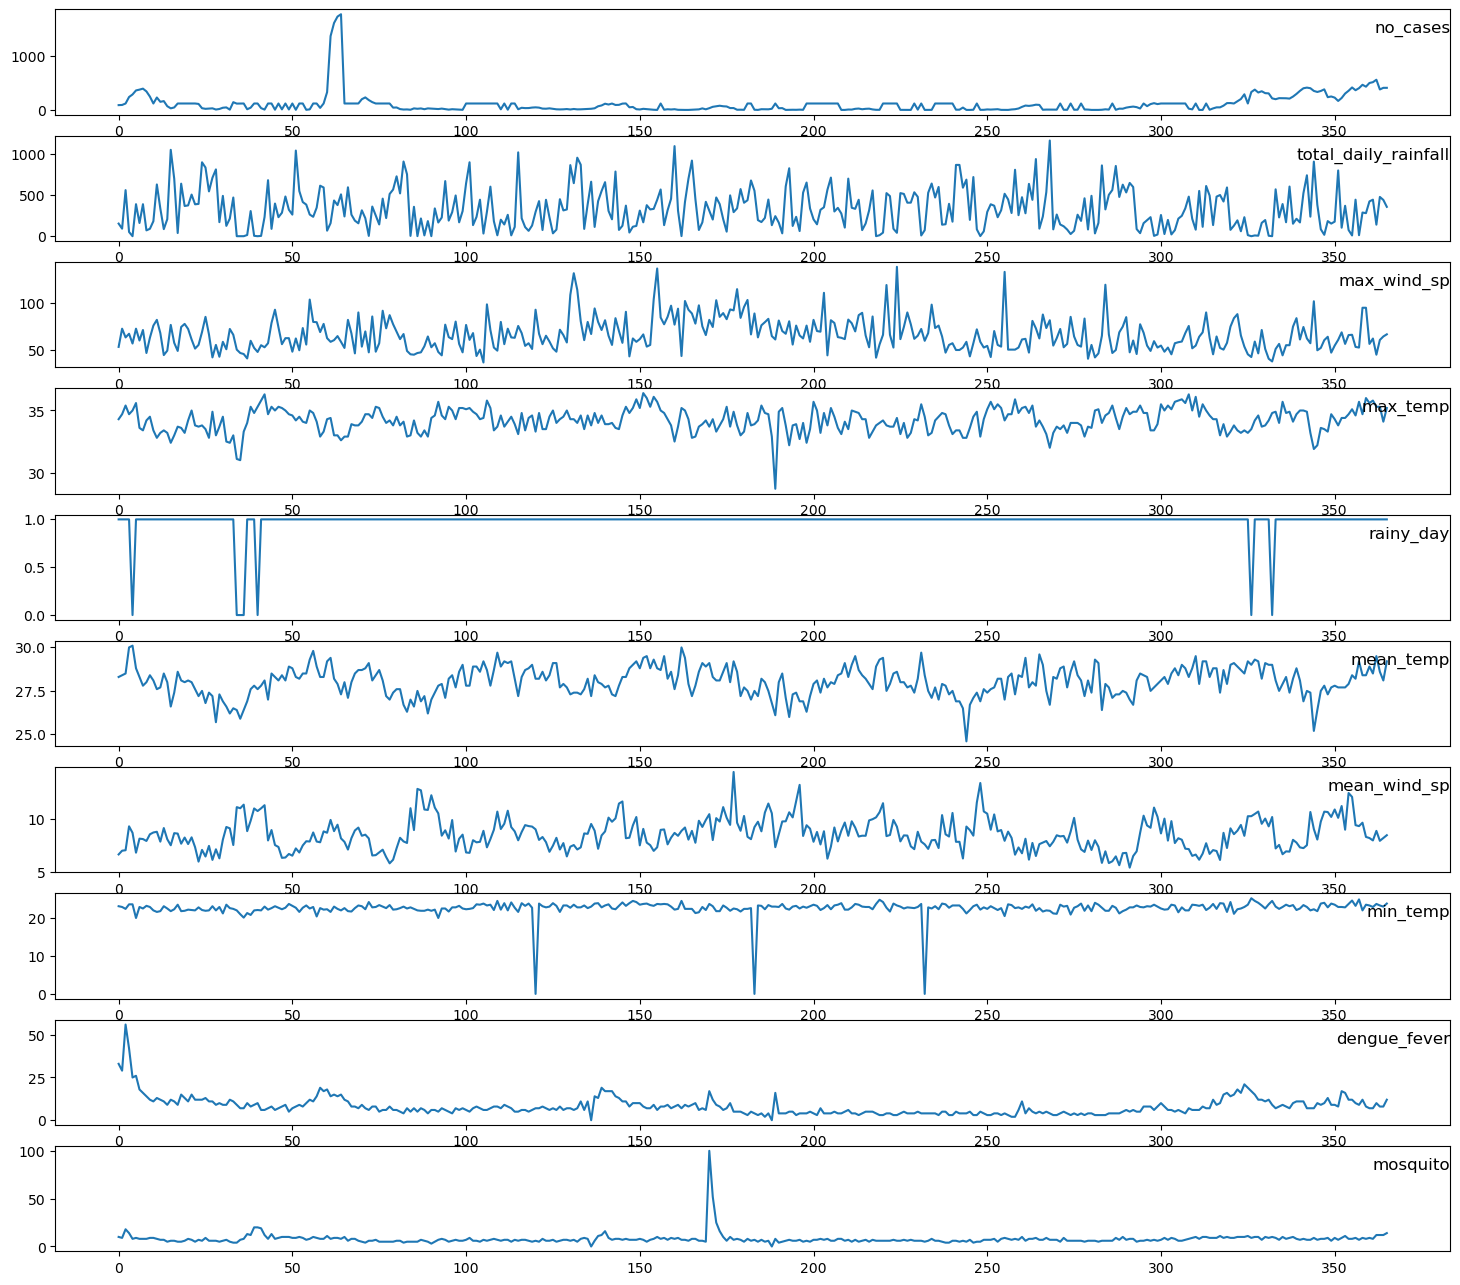

In [12]:
plot_data(df_west, possible_features)

Okay, now the trends seems much better!  
Okay, not really but it is better...   
Anyways, I will conduct the ACF test on the data.  
PACF measures the direct effect of data point at $t - n$ have on data point at $t$.  
ACF on the other hand measure both the direct effects and indirect effects of data point at $t - n$ have on data point at $t$.  

In my understanding of Dengue Cases, the direct effect should be lower.  
This is becasue you can't expect mosquitos from more than 4 weeks back to still be transmitting Dengue Fever.  
Since [NEA](https://www.nea.gov.sg/dengue-zika/prevent-aedes-mosquito-breeding/aedes-mosquito) stated that the average life span of an Aedes Mosquito is approximately 2 weeks.  

With this in mind, it makes more sense to look at the ACF result.  
(I am not looking at PACF result here on the notebook becasue it will make the notebook long.)   
(Yes, I have looked at the PACF results too.)

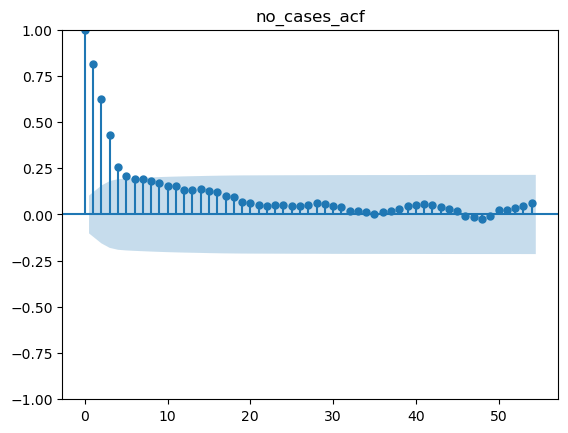

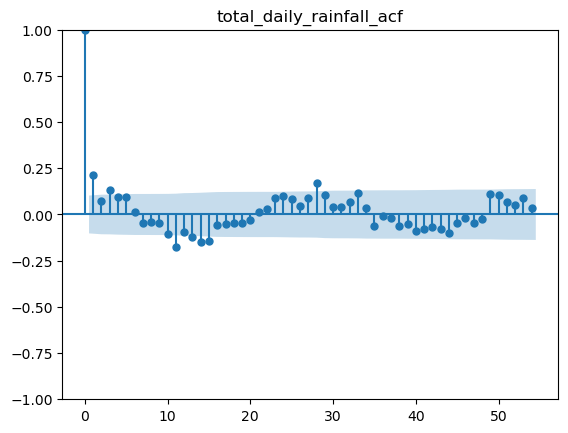

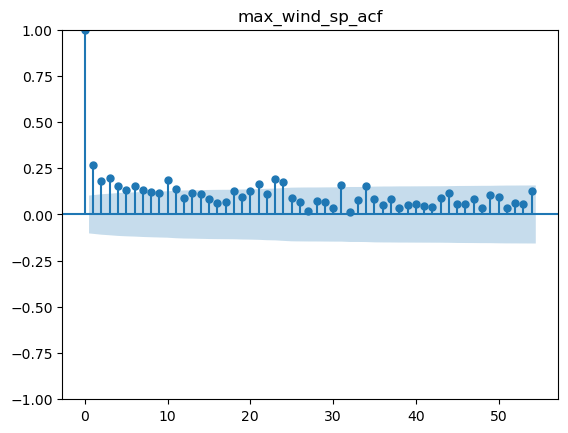

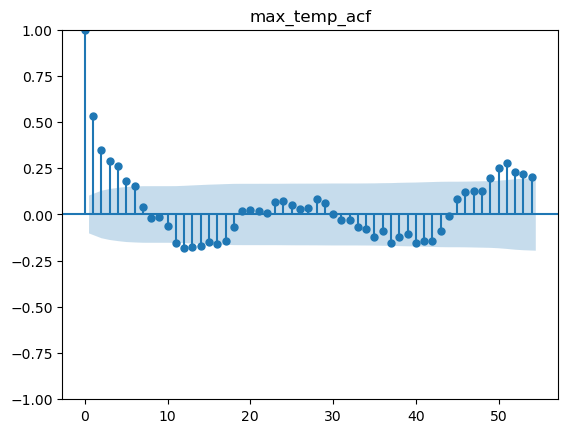

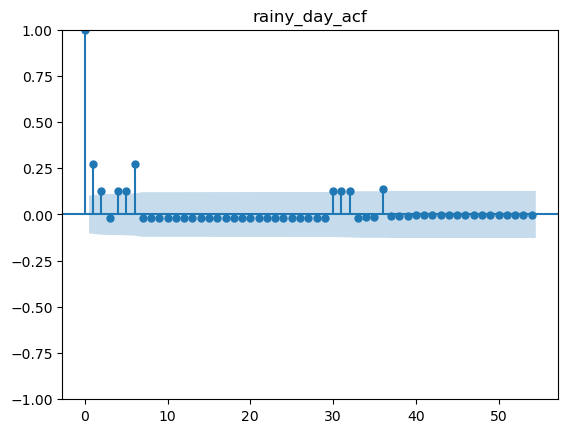

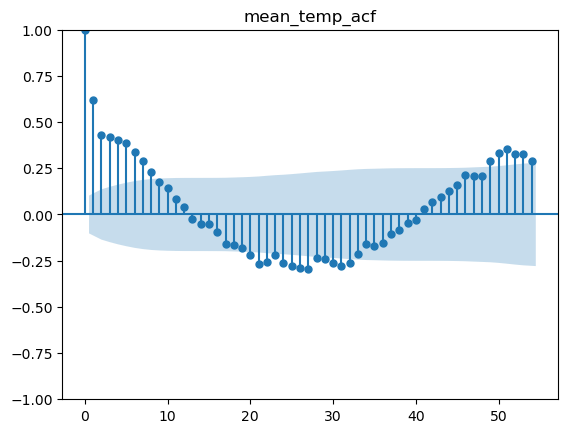

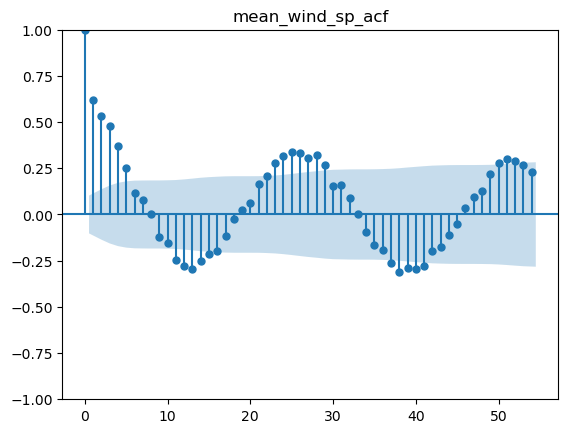

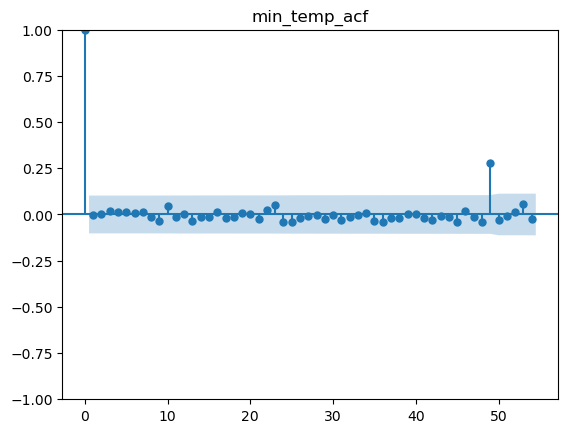

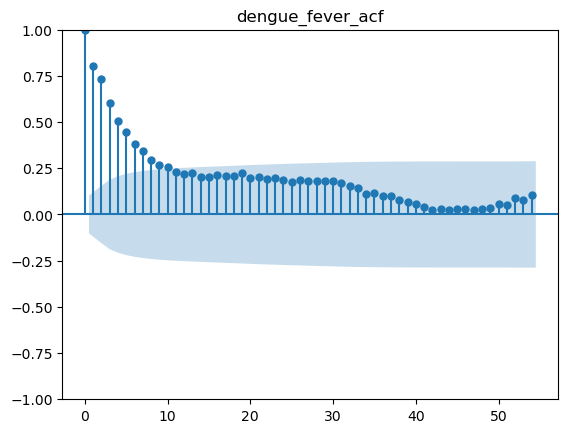

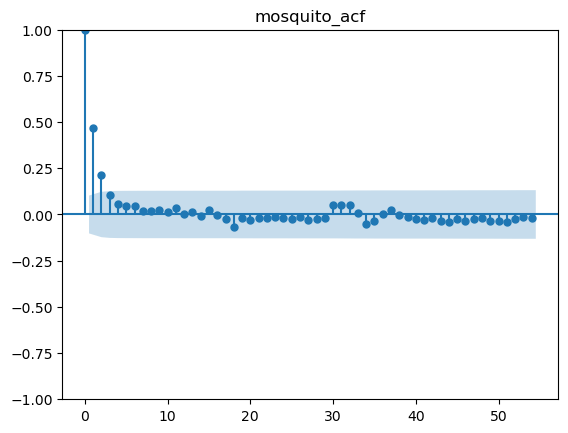

In [13]:
plot_my_ACF(df_west, possible_features)

From the ACF plot, we can see that the series is no a time_step of 6 or 12.  
6 covers most of the possible correlations.  
12 covers all the correlations.  

## Preprocessing

My `time_steps` will actually affect how I slice my data.  
For example, if my `time_steps` is 6, this means from data points 0 to 5, I will not have a y value.  
This is simply becasue my LSTM need a total of 6 data points to learn from.  
This calls for rigorous data preprocessing.  

The preprocessing of the input data is the most tideous part of all.   
I have to prepare the datas into appropriate arries in order to use it in my LSTM.

In [14]:
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

Step 1: Convert all data into numerical array  
Neural Network is a machine that uses gradient descent to find the best weights so that a proper curve can be approcimated.  
This only takes in numerical values.  

In [15]:
df_train = df_west

In [16]:
df_train.shape

(366, 23)

In [17]:
def df_to_mx_numerical(data:pd.DataFrame, feature_list:list, min_max:bool=False):
    '''This function takes in DataFrame, keeps only desired colmuns, and output a scaled numerical array.
    args:
        data: DataFrame to be processed
        feature_list: list of colmun headers that's useful     
    out:
        data_array: scaled data in an numerical array
    '''
    # only keep the relavent colmuns
    df = data[feature_list]
    # change the colmuns to array
    data_array = df.values
    # ensure all data is float
    data_array = data_array.astype('float32')
    if min_max:
        # standardise data
        scaler = StandardScaler()
        data_array = scaler.fit_transform(data_array)
    else:
        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_array = scaler.fit_transform(data_array)
    # save model future usage
    save_path = '../data/scaler.joblib'
    joblib.dump(scaler, save_path)
    return data_array

In [18]:
# Only keep the relavent colmuns
df_train = df_train[possible_features]
# Convert data to numerical array
df_array = df_to_mx_numerical(df_train, possible_features)

In [19]:
df_train.shape

(366, 10)

In [20]:
df_array.shape

(366, 10)

Now, for time series problem, I need to prepare my data in a way that my LSTM will be able to read it.  
It need to be converted from a time series data to something that can be feed to an LSTM.  
For example, I have time series data:  
```bash
[t-6, t-5, t-4, t-3, t-2, t-1, t]
```  
I want to 2 historical data points to predict the current data point.  
Then the data have to be prepared in this way:  
|   |   |
|---|---|  
|X|y|  
|```[t-6, t-5]```|```[t-4]```|  
|```[t-5, t-4]```|```[t-3]```|  
|```[t-4, t-3]```|```[t-2]```|  
|```[t-3, t-2]```|```[t-1]```|  
|```[t-2, t-1]```|```[t]```|  

Then I will feed in the 2 data points and their corresponding `y` into LSTM for training.  

In [21]:
# specify the number of data points from past to use
n_hours = 6
n_features = 10

In [22]:
# Convert time serie to supervised learning problem
def time_to_supervise(data, num_X_in:int=1, num_y_pred:int=1, dropnan:bool=True):
    '''Converts a time series data to supervised training data with target y.
    args:
        data: time series data input
        num_X_in: how data points from past are used to by LSTM for prediction
        num_y_pred: how many data points are expected to be predicted by LSTM
        dropnan: should Nan be dropped. If Flase, series will start with 0. 
            Default: replace Nan with 0.
    out:
        data_out: reshaped DataFrame that can be used for training
    '''
    # Check if data is a list
    n_vars = 1 if type(data) is list else data.shape[1]
    # convert data array back to data frame for manipulation
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(num_X_in, 0, -1):
        cols.append(df.shift(i))
        names += [('feature%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t, t+1, ... t+n)
    for i in range(0, num_y_pred):
         cols.append(df.shift(-i))
    if i == 0:
         names += [('feature%d(t)' % (j+1)) for j in range(n_vars)]
    else:
         names += [('feature%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
     # put it all together
    data_out = pd.concat(cols, axis=1)
    data_out.columns = names
     # drop rows with NaN values
    if dropnan:
         data_out.dropna(inplace=True)
    else:
        data_out[np.isnan(data_out)] = 0
    return data_out

Using time_to_supervise()

In [23]:
reframed = time_to_supervise(df_array, n_hours, 1)

In [24]:
reframed.shape

(360, 70)

In [25]:
reframed[:2]

,feature1(t-6),feature2(t-6),feature3(t-6),feature4(t-6),feature5(t-6),feature6(t-6),feature7(t-6),feature8(t-6),feature9(t-6),feature10(t-6),feature1(t-5),feature2(t-5),feature3(t-5),feature4(t-5),feature5(t-5),feature6(t-5),feature7(t-5),feature8(t-5),feature9(t-5),feature10(t-5),feature1(t-4),feature2(t-4),feature3(t-4),feature4(t-4),feature5(t-4),feature6(t-4),feature7(t-4),feature8(t-4),feature9(t-4),feature10(t-4),feature1(t-3),feature2(t-3),feature3(t-3),feature4(t-3),feature5(t-3),feature6(t-3),feature7(t-3),feature8(t-3),feature9(t-3),feature10(t-3),feature1(t-2),feature2(t-2),feature3(t-2),feature4(t-2),feature5(t-2),feature6(t-2),feature7(t-2),feature8(t-2),feature9(t-2),feature10(t-2),feature1(t-1),feature2(t-1),feature3(t-1),feature4(t-1),feature5(t-1),feature6(t-1),feature7(t-1),feature8(t-1),feature9(t-1),feature10(t-1),feature1(t),feature2(t),feature3(t),feature4(t),feature5(t),feature6(t),feature7(t),feature8(t),feature9(t),feature10(t)
6,0.050028,0.131757,0.162905,0.727273,1.0,0.672727,0.138038,0.916667,0.589286,0.10,0.051734,0.078729,0.353287,0.779221,1.0,0.690909,0.176965,0.908730,0.517857,0.09,0.067084,0.481539,0.262022,0.870130,1.0,0.709091,0.181908,0.888889,1.00,0.18,0.134736,0.044119,0.300294,0.779221,1.0,0.981818,0.431714,0.936508,0.750000,0.14,0.161455,0.000000,0.198234,0.818182,0.0,1.000000,0.364099,0.936508,0.446429,0.08,0.203525,0.334533,0.353287,0.896103,1.0,0.763637,0.156310,0.793651,0.464286,0.09,0.212052,0.137839,0.229637,0.636363,1.0,0.672727,0.303015,0.908730,0.321429,0.08
7,0.051734,0.078729,0.353287,0.779221,1.0,0.690909,0.176965,0.908730,0.517857,0.09,0.067084,0.481539,0.262022,0.870130,1.0,0.709091,0.181908,0.888889,1.000000,0.18,0.134736,0.044119,0.300294,0.779221,1.0,0.981818,0.431714,0.936508,0.75,0.14,0.161455,0.000000,0.198234,0.818182,0.0,1.000000,0.364099,0.936508,0.446429,0.08,0.203525,0.334533,0.353287,0.896103,1.0,0.763637,0.156310,0.793651,0.464286,0.09,0.212052,0.137839,0.229637,0.636363,1.0,0.672727,0.303015,0.908730,0.321429,0.08,0.222285,0.334276,0.339549,0.610390,1.0,0.581818,0.298602,0.892857,0.285714,0.08


In [26]:
# split into train and test sets
values = reframed.values
# n_train_hours = 365 * 24
# split the tarin and test here
n_train = int(values.shape[0]*(0.8))
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(288, 60) 288 (288,)
(288, 6, 10) (288,) (72, 6, 10) (72,)


Trying to achieve the same thing with slightly different method.  
This method is better in my opinion.  
Array all the way.  

In [27]:
def create_dataset(df, window_size:int=1, n:int=1, y_col:int=0):
    """
    Creates input and output data for an LSTM model from a pandas DataFrame or a list.
    args:
        df (pandas.DataFrame or list): The input data.
        window_size (int): The number of data points to use for making predictions.
        n (int): The number of data points to predict as output.
        y_col (int): The index of the column in df containing the output data.
    out:
        X (numpy.ndarray): The input data for the LSTM model.
        y (numpy.ndarray): The output data for the LSTM model.
    """
    # convert list to array
    if isinstance(df, list):
        df = np.array(df).reshape(-1, 1)
    # make empty list
    X, y = [], []
    # fill the list with data
    for i in range(len(df) - window_size - n + 1): #+1 becasue need to ensure enough data point is present
        # append window of [t-n, .., t-1] data for all colmuns to X
        X.append(df[i:i + window_size, :])
        # extarct the y value at time t and append it
        y.append(df[i + window_size:i + window_size + n, y_col])

    X = np.array(X)
    y = np.array(y)
    
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)

    return X, y

In [64]:
X_array, y_array = create_dataset(df_array, n_hours, 1, 0)

In [65]:
print(f"X_array shape: {X_array.shape}, y_array shape: {y_array.shape}")

X_array shape: (360, 6, 10), y_array shape: (360, 1)


In [66]:
train_size = int(len(X_array) * 0.8)
test_size = len(X_array) - train_size
X_train, X_test = X_array[:train_size], X_array[train_size:]
y_train, y_test = y_array[:train_size], y_array[train_size:]

In [67]:
print(f"X_tarin shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_tarin shape: (288, 6, 10), y_train shape: (288, 1), X_test shape: (72, 6, 10), y_test shape: (72, 1)


## Model Creation

In [68]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

In [69]:
# callback for early stopping condition
callback = EarlyStopping(monitor='val_loss', patience=4)

In [70]:
# design network
model = Sequential()
# model.add(LSTM(64, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(6, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2]))) 
# model.add(Dense(32, activation='relu')) 
# model.add(Dense(6, activation='relu')) 
# model.add(Dense(2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

2023-04-15 02:39:40.103529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 02:39:40.104794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 02:39:40.105818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6)                 408       
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 415
Trainable params: 415
Non-trainable params: 0
_________________________________________________________________


## Training

In [72]:
X_train.shape

(288, 6, 10)

In [73]:
# fit network
history = model.fit(X_train, y_train, epochs=5, batch_size=288, validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False, callbacks=[callback])

Epoch 1/5


2023-04-15 02:39:40.772218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 02:39:40.773902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 02:39:40.774821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step - loss: 0.3285 - accuracy: 0.0590 - val_loss: 0.2664 - val_accuracy: 0.0278
Epoch 2/5
1/1 [==============================] - 0s 43ms/step - loss: 0.3036 - accuracy: 0.0625 - val_loss: 0.2435 - val_accuracy: 0.0278
Epoch 3/5
1/1 [==============================] - 0s 44ms/step - loss: 0.2697 - accuracy: 0.0694 - val_loss: 0.2205 - val_accuracy: 0.0278


2023-04-15 02:39:41.952733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 02:39:41.954516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 02:39:41.955320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 4/5
1/1 [==============================] - 0s 37ms/step - loss: 0.2503 - accuracy: 0.0625 - val_loss: 0.1975 - val_accuracy: 0.0278
Epoch 5/5
1/1 [==============================] - 0s 35ms/step - loss: 0.2221 - accuracy: 0.0660 - val_loss: 0.1755 - val_accuracy: 0.0278


## Results 

In [74]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], n_hours*n_features))

3/3 [==============================] - 0s 3ms/step


2023-04-15 02:39:42.376677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 02:39:42.377949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 02:39:42.378934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [75]:
scaler = joblib.load('../data/scaler.joblib')

In [76]:
# history.history
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, X_test[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 337.712


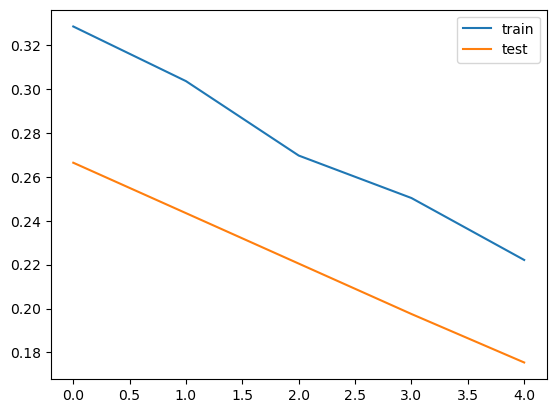

In [77]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [78]:
df_west.tail()

,yr,week,region,no_cases,total_daily_rainfall,max_wind_sp,max_temp,rainy_day,mean_temp,mean_wind_sp,min_temp,dengue_fever,dengue,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
361,2020,15,West,512,445.5,62.2,35.8,1,28.5,7.941304,22.9,7.0,6.0,8.0,2.0,0.0,1.0,0.0,2.0,-1.0,-2.0,0.0,1.0
362,2020,16,West,557,140.9,45.0,35.3,1,29.5,8.840426,23.7,10.0,10.0,12.0,2.0,3.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0
363,2020,17,West,378,479.0,60.7,35.3,1,28.6,7.906250,23.3,8.0,8.0,12.0,3.0,-2.0,-5.0,-2.0,-6.0,0.0,-4.0,1.0,1.0
364,2020,18,West,408,442.6,64.4,34.1,1,28.1,8.164444,23.0,8.0,7.0,12.0,4.0,0.0,2.0,-1.0,1.0,0.0,0.0,1.0,0.0
365,2020,19,West,408,358.2,66.7,35.2,1,29.2,8.434146,23.8,12.0,11.0,14.0,4.0,4.0,4.0,4.0,5.0,2.0,2.0,0.0,-1.0


In [79]:
inv_y

array([ 28.      , 120.00001 ,  71.      , 109.      , 126.      ,
       109.      , 120.00001 , 120.00001 , 120.00001 , 120.00001 ,
       120.00001 , 120.00001 , 120.00001 , 120.00001 ,  25.      ,
        12.      , 120.00001 ,   2.      ,   2.      , 120.00001 ,
         5.      ,  30.000002,  49.      ,  49.      ,  80.      ,
       127.00001 , 128.      , 120.00001 , 162.      , 202.      ,
       289.      , 120.00001 , 331.      , 375.      , 322.      ,
       345.      , 310.      , 306.      , 214.      , 199.      ,
       218.      , 218.      , 216.      , 210.      , 247.00002 ,
       296.      , 352.      , 400.      , 412.      , 401.      ,
       351.      , 332.      , 350.      , 380.      , 236.00002 ,
       249.      , 228.      , 167.      , 221.      , 303.      ,
       354.      , 415.      , 364.      , 402.      , 464.      ,
       429.      , 497.      , 512.      , 557.      , 378.      ,
       408.      , 408.      ], dtype=float32)

In [80]:
inv_yhat = np.around(inv_yhat)
inv_yhat

array([161., 156., 258., 358., 415., 457., 523., 599., 610., 569., 568.,
       493., 496., 465., 407., 413., 318., 288., 258., 159., 214., 244.,
       263., 309., 321., 452., 509., 459., 474., 473., 539., 580., 616.,
       579., 654., 733., 707., 746., 726., 641., 656., 557., 578., 444.,
       451., 380., 340., 377., 397., 489., 554., 572., 588., 598., 625.,
       646., 657., 709., 780., 816., 846., 881., 903., 913., 826., 782.,
       689., 691., 678., 678., 686., 669.], dtype=float32)

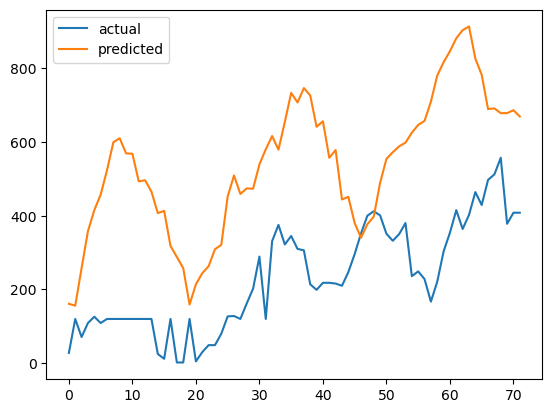

In [81]:
plt.plot(range(len(test_y)),inv_y)
plt.plot(range(len(test_y)),inv_yhat)
plt.legend(['actual', 'predicted'])
plt.show()

## Conclusion

LSTM and Neural Network isn't magic!    
They require good data to make accurate predictions.  
What I have demonstrated here is an epic exmaple of insufficent data, and data used not refelcting trend, plus unclear trend.  
Hence, the result from LSTM is unsightly!  
The LSTM however, is able to predict some peaks/ spikes (sometimes).